In [29]:
import sys
sys.path.append('/home/epinyoan/git/smplpytorch/')

%reload_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import os
import torch
import argparse
from os.path import join as pjoin

import utils.paramUtil as paramUtil
from torch.utils.data import DataLoader
from utils.plot_script import *
from utils.get_opt import get_opt
from datasets.evaluator_models import MotionLenEstimatorBiGRU

from trainers import DDPMTrainer
from models import MotionTransformer
from utils.word_vectorizer import WordVectorizer, POS_enumerator
from utils.utils import *
from utils.motion_process import recover_from_ric, recover_from_rot, recover_root_rot_pos, quaternion_to_cont6d
from utils.skeleton import Skeleton

In [30]:
def build_models(opt):
    encoder = MotionTransformer(
        input_feats=opt.dim_pose,
        num_frames=opt.max_motion_length,
        num_layers=opt.num_layers,
        latent_dim=opt.latent_dim,
        no_clip=opt.no_clip,
        no_eff=opt.no_eff)
    return encoder
class Args:
    opt_path = 'checkpoints/t2m/t2m_motiondiffuse/opt.txt'
    text = 'a person runs happily, always move in circle'
    motion_length = 120
    result_path = ''
    gpu_id = 0

args=Args()
device = torch.device('cuda')
opt = get_opt(args.opt_path, device)
opt.do_denoise = True

assert opt.dataset_name == "t2m"
assert args.motion_length <= 196
opt.data_root = './dataset/HumanML3D'
opt.motion_dir = pjoin(opt.data_root, 'new_joint_vecs')
opt.text_dir = pjoin(opt.data_root, 'texts')
opt.joints_num = 22
opt.dim_pose = 263
dim_word = 300
dim_pos_ohot = len(POS_enumerator)
num_classes = 200 // opt.unit_length

mean = np.load(pjoin(opt.meta_dir, 'mean.npy'))
std = np.load(pjoin(opt.meta_dir, 'std.npy'))

encoder = build_models(opt).to(device)
trainer = DDPMTrainer(opt, encoder)
trainer.load(pjoin(opt.model_dir, opt.which_epoch + '.tar'))

trainer.eval_mode()
trainer.to(opt.device)

result_dict = {}

Reading checkpoints/t2m/t2m_motiondiffuse/opt.txt


In [31]:
with torch.no_grad():
    if args.motion_length != -1:
        caption = [args.text]
        m_lens = torch.LongTensor([args.motion_length]).to(device)
        pred_motions = trainer.generate(caption, m_lens, opt.dim_pose)
        motion = pred_motions[0].cpu().numpy()
        motion = motion * std + mean
        title = args.text + " #%d" % motion.shape[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [32]:
data = torch.from_numpy(motion)
data.shape

torch.Size([120, 263])

In [33]:
joint = recover_from_ric(torch.from_numpy(motion).float(), opt.joints_num).numpy()

data: torch.Size([120, 263]) r_rot_quat: torch.Size([120, 4])
positions: torch.Size([120, 63])
positions2: torch.Size([120, 21, 3])
positions3: torch.Size([120, 21, 3])
positions4: torch.Size([120, 22, 3])


In [34]:
import plotly.graph_objects as go
def get_range(skeleton, index):
    _min, _max = skeleton[:,:,index].min(), skeleton[:,:,index].max()
    return [_min, _max], _max-_min
def animate3d(skeleton, BONE_LINK=None):
    # [animation] https://community.plotly.com/t/3d-scatter-animation/46368/6
    skeleton = skeleton.copy()
#     skeleton = -skeleton
    skeleton[:, :, [1, 2]] = skeleton[:, :, [2, 1]]
    SHIFT_SCALE = 0
    START_FRAME = 0
    NUM_FRAMES = skeleton.shape[0]
    skeleton = skeleton[START_FRAME:NUM_FRAMES+START_FRAME]
    
    if BONE_LINK is not None:
        # ground truth
        bone_ids = np.array(BONE_LINK)
        _from = skeleton[:, bone_ids[:, 0]]
        _to = skeleton[:, bone_ids[:, 1]]
        # [f 3(from,to,none) d]
        bones = np.empty((_from.shape[0], 3*_from.shape[1], 3), dtype=_from.dtype)
        bones[:, 0::3] = _from
        bones[:, 1::3] = _to
        bones[:, 2::3] = np.full_like(_to, None)
        display_points = bones
        mode = 'lines+markers'
    else:
        display_points = skeleton
        mode = 'markers'

    
    frames = [go.Frame(data= [go.Scatter3d(
                        x=display_points[k,:,0], 
                        y=display_points[k,:,1], 
                        z=display_points[k,:,2], 
                        mode=mode, 
                        marker = dict(size = 3, ))],
                   traces= [0],
                   name=f'frame{k}'      
                  )for k  in  range(len(display_points)-1)]
    
    fig = go.Figure(
        data=[
        go.Scatter3d(x=display_points[0,:,0], y=display_points[0,:,1], z=display_points[0,:,2], mode=mode, marker = dict(size = 3, )),
    ], layout = go.Layout(scene = dict(aspectmode= 'data', camera=dict(eye=dict(x=3, y=0, z=0.1)))))
    fig.update(frames=frames)
    def frame_args(duration):
        return {
                "frame": {"duration": duration},
                "mode": "immediate",
                "fromcurrent": True,
                "transition": {"duration": duration, "easing": "linear"},
                }


    sliders = [
        {"pad": {"b": 10, "t": 60},
         "len": 0.9,
         "x": 0.1,
         "y": 0,

         "steps": [
                     {"args": [[f.name], frame_args(0)],
                      "label": str(k),
                      "method": "animate",
                      } for k, f in enumerate(fig.frames)
                  ]
         }
            ]

    fig.update_layout(
        updatemenus = [{"buttons":[
                        {
                            "args": [None, frame_args(1000/25)],
                            "label": "Play", 
                            "method": "animate",
                        },
                        {
                            "args": [[None], frame_args(0)],
                            "label": "Pause", 
                            "method": "animate",
                      }],

                    "direction": "left",
                    "pad": {"r": 10, "t": 70},
                    "type": "buttons",
                    "x": 0.1,
                    "y": 0,
                }
             ],
             sliders=sliders
        )
    range_x, aspect_x = get_range(skeleton,0)
    range_y, aspect_y = get_range(skeleton,1)
    range_z, aspect_z = get_range(skeleton,2)
    
    fig.update_layout(scene = dict(xaxis=dict(range=range_x,),
                                   yaxis=dict(range=range_y,),
                                   zaxis=dict(range=range_z,)
                                   ),
                      scene_aspectmode='manual',
                      scene_aspectratio=dict(x=aspect_x, y=aspect_y, z=aspect_z)
                      )

    fig.update_layout(sliders=sliders)
    fig.show()

In [35]:
# joint2smpl
# 1.
# temp = keypoints_3d.cpu()
# root = (temp[:,1:2]+temp[:,2:3])/2
# temp = torch.cat((root, temp), axis=1)
# temp = temp.numpy()
# # 2.
# pred_pose_reshape = pred_pose.detach().cpu().reshape(1,24,3).numpy()
# # 3.
# new_opt_joints[:,:24].cpu().numpy()

In [36]:
# paramUtil.t2m_kinematic_chain
t2m_bone = [[0,2], [2,5],[5,8],[8,11],
            [0,1],[1,4],[4,7],[7,10],
            [0,3],[3,6],[6,9],[9,12],[12,15],
            [9,14],[14,17],[17,19],[19,21],
            [9,13],[13,16],[16,18],[18,20]]
animate3d(joint, BONE_LINK=t2m_bone)

### Forward Kinematics

In [37]:
tgt_skel = Skeleton(torch.from_numpy(paramUtil.t2m_raw_offsets), paramUtil.t2m_kinematic_chain, 'cpu')
tgt_offsets = tgt_skel.get_offsets_joints(torch.from_numpy(joint[0]))
tgt_skel.set_offset(tgt_offsets)

# joint = recover_from_ric(torch.from_numpy(motion).float(), opt.joints_num).numpy()
joint2 = recover_from_rot(torch.from_numpy(motion).float(), opt.joints_num, tgt_skel).numpy()
animate3d(joint2, BONE_LINK=t2m_bone)

In [38]:
axis_angle.shape

torch.Size([115, 72])

In [39]:
# Face direction, r_hip, l_hip, sdr_r, sdr_l
face_joint_indx = [2, 1, 17, 16]
quat_params = tgt_skel.inverse_kinematics_np(joint, face_joint_indx)
axis_angle = quaternion_to_axis_angle(torch.from_numpy(quat_params))
axis_angle = torch.cat([axis_angle,torch.zeros((120,1,3))], axis=1)
axis_angle = axis_angle.reshape((-1,72)).float()

### SMPL

In [40]:
from smplpytorch.pytorch.smpl_layer import SMPL_Layer
from display_utils import display_model

In [41]:
batch_size = 1
smpl_layer = SMPL_Layer(
        center_idx=0,
        gender='male',
        model_root='/home/epinyoan/git/smplpytorch/smplpytorch/native/models')

In [42]:
from pytorch3d.transforms import quaternion_to_axis_angle, \
                                    matrix_to_quaternion, \
                                    matrix_to_axis_angle, \
                                    rotation_6d_to_matrix, \
                                    matrix_to_euler_angles
# _joint = matrix_to_axis_angle(rotation_6d_to_matrix(joint))
# # joint[0:1].reshape((1,-1)).shape
# _joint = torch.cat([_joint, torch.zeros((120,1,3)), torch.zeros((120,1,3))], axis=1)
# # _joint = _joint[:,1:]
# _joint = _joint.reshape((120,-1))
# _joint.shape

In [43]:
# _joint = torch.from_numpy(motion).float()
# _joint = _joint[:, 4:4+21*3]
# _joint = _joint.reshape((120,-1, 3))
# _joint = torch.cat([torch.zeros((120,1,3)), _joint, torch.zeros((120,1,3)), torch.zeros((120,1,3))], axis=1)
# _joint = _joint.reshape((120,-1))
# _joint = _joint[10:11] 
# _joint.shape

##### 1. joints
"Get Joint Rotation Invariant Position Represention" (recover_from_ric)<br>
see [here](https://github.com/EricGuo5513/HumanML3D/blob/3ea8be34e31eb7aaf4a1a5781bbd352da48c2633/motion_representation.ipynb)

In [44]:
# _joint = recover_from_ric(torch.from_numpy(motion).float(), opt.joints_num).numpy()
# _joint = torch.cat([torch.from_numpy(_joint), torch.zeros((120,1,3)), torch.zeros((120,1,3))], axis=1)
# _joint = _joint[:1, 1:] # (120,23,3)
# _joint = _joint.reshape((-1,72))

##### 2. raw data (no recover_from_ric)

In [45]:
_raw_motion = torch.from_numpy(motion)
_raw_motion = _raw_motion[..., 4:(22 - 1) * 3 + 4]
_raw_motion = _raw_motion[0:1].reshape((1,-1,3))
_raw_motion = torch.cat([torch.zeros((1,1,3)), _raw_motion, torch.zeros((1,1,3)), torch.zeros((1,1,3))], axis=1)
_raw_motion = _raw_motion.reshape((1,72))

##### 3. 6d

In [46]:
import torch.nn.functional as F
def rot6d_to_rotmat(x):
    """Convert 6D rotation representation to 3x3 rotation matrix.
    Based on Zhou et al., "On the Continuity of Rotation Representations in Neural Networks", CVPR 2019
    Input:
        (B,6) Batch of 6-D rotation representations
    Output:
        (B,3,3) Batch of corresponding rotation matrices
    """
    x = x.view(-1,3,2)
    a1 = x[:, :, 0]
    a2 = x[:, :, 1]
    b1 = F.normalize(a1)  # Ensuring columns are unit vectors
    b2 = F.normalize(a2 - torch.einsum('bi,bi->b', b1, a2).unsqueeze(-1) * b1)  # Ensuring column 1 and column 2 are orthogonal
    b3 = torch.cross(b1, b2)
    return torch.stack((b1, b2, b3), dim=-1)

In [47]:
# rotMat = np.zeros((3, 3), np.float32)
# rotVec,_ = cv2.Rodrigues(rotMat)
# cont6d_params.cpu().numpy().shape

In [50]:
# https://github.com/akashsengupta1997/STRAPS-3DHumanShapePose/issues/12
def _3x3_to_axis_angle(x):
    axis_angles = []
    for _x in x:
        rotVec,_ = cv2.Rodrigues(_x)
        axis_angles.append(rotVec)
    axis_angles = np.array(axis_angles).reshape((120,22,3))
    return torch.from_numpy(axis_angles)
axis_angle = _3x3_to_axis_angle(cont6d_params.cpu().numpy())
axis_angle.shape

error: OpenCV(4.6.0) /io/opencv/modules/calib3d/src/calibration.cpp:3476: error: (-2:Unspecified error) in function 'void cv::Rodrigues(cv::InputArray, cv::OutputArray, cv::OutputArray)'
> Input matrix must be 1x3 or 3x1 for a rotation vector, or 3x3 for a rotation matrix:
>     'srcSz == Size(3, 1) || srcSz == Size(1, 3) || (srcSz == Size(1, 1) && src.channels() == 3) || srcSz == Size(3, 3)'
> where
>     'srcSz' is [6 x 22]


In [49]:
from pytorch3d.transforms import matrix_to_axis_angle, \
                                    rotation_6d_to_matrix, \
                                    matrix_to_euler_angles,  axis_angle_to_matrix
import cv2
joints_num = 22
r_rot_quat, r_pos = recover_root_rot_pos(data)

r_rot_cont6d = quaternion_to_cont6d(r_rot_quat)

start_indx = 1 + 2 + 1 + (joints_num - 1) * 3
end_indx = start_indx + (joints_num - 1) * 6
cont6d_params = data[..., start_indx:end_indx]
# print(r_rot_cont6d.shape, cont6d_params.shape, r_pos.shape)
cont6d_params = torch.cat([r_rot_cont6d, cont6d_params], dim=-1)
cont6d_params = cont6d_params.view(-1, joints_num, 6)

# 1. 3x3 [rot6d_to_rotmat]
# rotmat_params = rot6d_to_rotmat(cont6d_params)
# axis_angle = _3x3_to_axis_angle(rotmat_params.cpu().numpy())
# print('axis_angles:', axis_angle.shape)

# 2. matrix_to_axis_angle
axis_angle = matrix_to_axis_angle(rotation_6d_to_matrix(cont6d_params))

# 3. matrix_to_euler_angles
# axis_angle = matrix_to_euler_angles(rotation_6d_to_matrix(cont6d_params), convention='ZYX') # convention need to verify

zeros = torch.zeros((120,1,3))
print('axis_angle:', axis_angle.shape)
axis_angle = torch.cat([axis_angle, zeros, zeros], axis=1)
axis_angle = axis_angle.reshape((120, -1))
axis_angle.shape

axis_angle: torch.Size([120, 22, 3])


torch.Size([120, 72])

In [51]:
# 4. directly call with th_pose_rotmat (3x3:=>9)
# axis_angle_to_matrix(axis_angle[:1].view(1,24,3)[:,:22]).squeeze() == rotation_6d_to_matrix(cont6d_params)[0]
eye = torch.eye(3,3).view(1,1,3,3)
cont6d_params_added_hands = rotation_6d_to_matrix(cont6d_params)[0:1]
cont6d_params_added_hands = torch.cat([cont6d_params_added_hands,eye,eye], axis=1)
cont6d_params_added_hands = cont6d_params_added_hands.view(1,-1)
###### line 74-76 smpl_layer.py need to be replaced with these lines:
# th_pose_rotmat = th_pose_axisang
# batch_size = th_pose_rotmat.shape[0]

In [52]:
def zero_joint(data, zero_indexes):
    data = data.reshape((1,-1,3)).clone()
    data[:, zero_indexes] = torch.zeros((1,len(zero_indexes),3))
    return data.reshape((1,-1))

In [53]:
axis_angle[0:1].shape

torch.Size([1, 72])

<IPython.core.display.Javascript object>


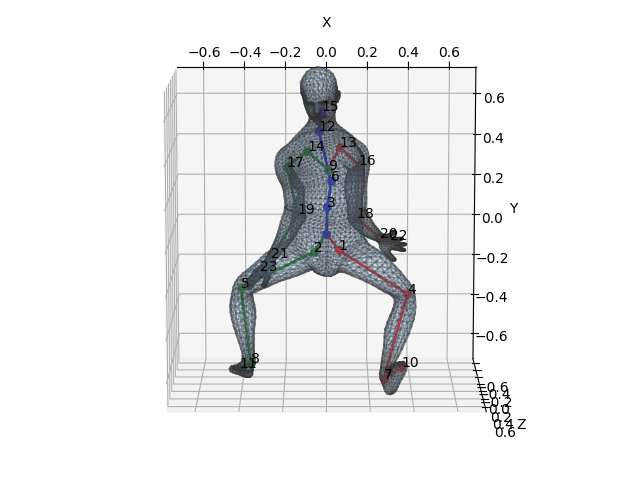

In [64]:
# temp_joints = torch.zeros((1,24, 3))
# temp_joints[0,19] = torch.tensor([0,3.14/2,0])
# temp_joints = temp_joints.reshape((1,-1))
# temp_joints.shape

batch_size = 1
pose_params = axis_angle[0:1] #zero_joint(axis_angle[0:1], [13,16, 18, 20]) #_joint #_raw_motion #_joint # torch.zeros((1,72)) #
shape_params = torch.rand(batch_size, 10) * 0.03

# pose_params = pose_params.cuda()
# shape_params = shape_params.cuda()
# smpl_layer.cuda()

# Forward from the SMPL layer
verts, Jtr = smpl_layer(pose_params, th_betas=shape_params)
plt.close()
ax = display_model(
        {'verts': verts.cpu().detach(),
         'joints': Jtr.cpu().detach()},
        model_faces=smpl_layer.th_faces,
        with_joints=True,
        kintree_table=smpl_layer.kintree_table,
        savepath=None,
        show=True)

### joints2smpl

In [55]:
from __future__ import print_function, division
import argparse
import torch
import os,sys
from os import walk, listdir
from os.path import isfile, join
import numpy as np
import joblib
import smplx
import trimesh
import h5py

sys.path.append('/home/epinyoan/git/joints2smpl')
sys.path.append('/home/epinyoan/git/joints2smpl/src')

from smplify import SMPLify3D
import config

# parsing argmument
class Args:
    batchSize=1
    num_joints=22
    joint_category="AMASS"
    num_smplify_iters=100
    files="test_motion.npy"
opt=Args()

# ---load predefined something
device = torch.device("cuda")
print(config.SMPL_MODEL_DIR)
smplmodel = smplx.create(config.SMPL_MODEL_DIR, 
                         model_type="smpl", gender="male", ext="pkl",
                         batch_size=opt.batchSize).to(device)

# ## --- load the mean pose as original ---- 
smpl_mean_file = config.SMPL_MEAN_FILE

file = h5py.File(smpl_mean_file, 'r')
init_mean_pose = torch.from_numpy(file['pose'][:]).unsqueeze(0).float()
init_mean_shape = torch.from_numpy(file['shape'][:]).unsqueeze(0).float()
cam_trans_zero = torch.Tensor([0.0, 0.0, 0.0]).to(device)
#
pred_pose = torch.zeros(opt.batchSize, 72).to(device)
pred_betas = torch.zeros(opt.batchSize, 10).to(device)
pred_cam_t = torch.zeros(opt.batchSize, 3).to(device)
keypoints_3d = torch.zeros(opt.batchSize, opt.num_joints, 3).to(device)

# # #-------------initialize SMPLify
smplify = SMPLify3D(smplxmodel=smplmodel,
                    batch_size=opt.batchSize,
                    joints_category=opt.joint_category,
					num_iters=opt.num_smplify_iters,
                    device=device)
#print("initialize SMPLify3D done!")

    
# --- load data ---
data = np.load("/home/epinyoan/git/joints2smpl/demo/demo_data/test_motion.npy")


# run the whole seqs
num_seqs = data.shape[0]

for idx in range(1):
	#print(idx)

	joints3d = data[idx] #*1.2 #scale problem [check first]	
	keypoints_3d[0, :, :] = torch.Tensor(joints3d).to(device).float()

	if idx == 0:
		pred_betas[0, :] = init_mean_shape
		pred_pose[0, :] = init_mean_pose
		pred_cam_t[0, :] = cam_trans_zero
	else:
		data_param = joblib.load(dir_save + "/" + "%04d"%(idx-1) + ".pkl")
		pred_betas[0, :] = torch.from_numpy(data_param['beta']).unsqueeze(0).float()
		pred_pose[0, :] = torch.from_numpy(data_param['pose']).unsqueeze(0).float()
		pred_cam_t[0, :] = torch.from_numpy(data_param['cam']).unsqueeze(0).float()
	
	pred_pose = pred_pose.reshape(1,-1,3)
	pred_pose[:,:,1] -= 1
	pred_pose = pred_pose.reshape(1,-1)
    
	if opt.joint_category =="AMASS":
		confidence_input =  torch.ones(opt.num_joints)
		# make sure the foot and ankle
	else:
		print("Such category not settle down!")
	print('------')  
	# ----- from initial to fitting -------
	new_opt_vertices, new_opt_joints, new_opt_pose, new_opt_betas, \
	new_opt_cam_t, new_opt_joint_loss = smplify(
												pose_params.cuda(),#pred_pose.detach(),
												shape_params.cuda(),#pred_betas.detach(),
												pred_cam_t.detach(),
												torch.from_numpy(joint[:1]).cuda(), #Jtr[:,:22].detach().cuda(), #keypoints_3d, #new_opt_joints[:,:22], # torch.from_numpy(joint[:1, 1:23]).cuda(), #
												conf_3d=confidence_input.to(device),
												seq_ind=idx
												)

	print('new_opt_vertices:', new_opt_vertices.shape)

/home/epinyoan/git/joints2smpl/smpl_models/
------
new_opt_vertices: torch.Size([1, 6890, 3])


In [56]:
plt.close()
ax = display_model(
        {'verts': new_opt_vertices.detach().cpu(),
         'joints': new_opt_joints[:,:24].detach().cpu()},
        model_faces=smpl_layer.th_faces,
        with_joints=True,
        kintree_table=smpl_layer.kintree_table,
        savepath=None,
        show=True)

<IPython.core.display.Javascript object>

In [58]:
from study.joints2smpl import Joint2SMPL

In [66]:
pose_params.shape, joint.shape

(torch.Size([1, 72]), (120, 22, 3))

/home/epinyoan/git/joints2smpl/smpl_models/
------


<IPython.core.display.Javascript object>


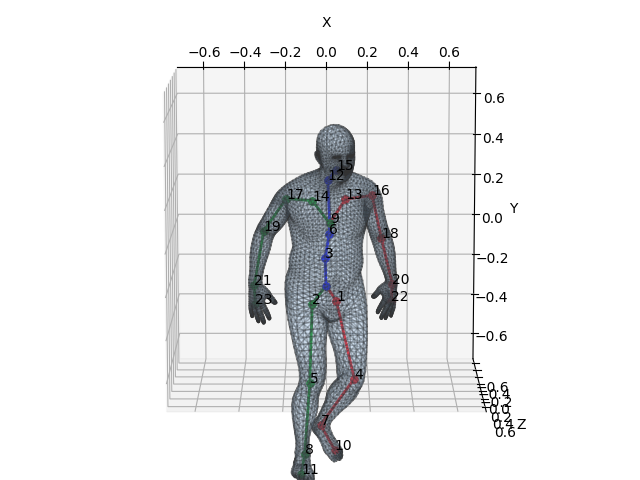

In [65]:
j2smpl = Joint2SMPL()
new_opt_vertices, new_opt_joints, new_opt_pose, new_opt_betas, \
            new_opt_cam_t, new_opt_joint_loss = j2smpl.run(pose_params, joint)
plt.close()
ax = display_model(
        {'verts': new_opt_vertices.detach().cpu(),
         'joints': new_opt_joints[:,:24].detach().cpu()},
        model_faces=smpl_layer.th_faces,
        with_joints=True,
        kintree_table=smpl_layer.kintree_table,
        savepath=None,
        show=True)

In [124]:
# https://github.com/EricGuo5513/HumanML3D/blob/main/body_models/smplh/male/model.npz
body_model = np.load('model.npz', mmap_mode='r')
for k in body_model.files:
    print(k, body_model[k].shape)


FileNotFoundError: [Errno 2] No such file or directory: 'model.npz'

In [ ]:
smpl_layer.kintree_table.shape

In [ ]:
body_model['kintree_table'].shape